In [1]:
# Make own packages auto reload
%load_ext autoreload
%autoreload 2

In [2]:
from plot import plot_mosaics, plot_blobs
from simulate import simulate_rgc_mosaics

n_mosaics = 3
center_noise = 0.1  # Position noise
diameter_noise = 0.1

mean_diameters = [10., 12.0, 15.0]  # Mean diameter for each mosaic
n_missing_list = [0, 0, 0]  # Missing cells per mosaic
overlap_factors = [1, 1, 1]  # No overlap, 15% overlap, 10% gaps

# Generate mosaics
groups, polygons, centers, clipped = simulate_rgc_mosaics(
    n_mosaics=n_mosaics,
    mean_diameters=mean_diameters,
    center_noise=center_noise,
    diameter_noise=diameter_noise,
    n_missing_list=n_missing_list,
    overlap_factors=overlap_factors,
)

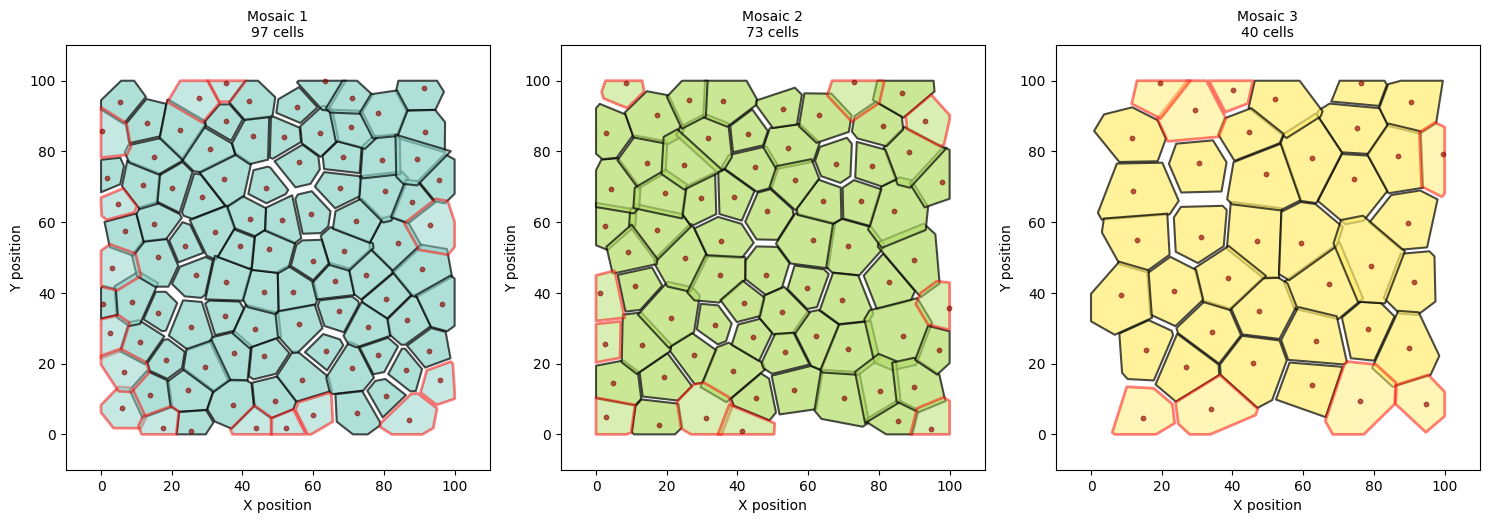

In [3]:
plot_mosaics(groups, polygons, centers, clipped)

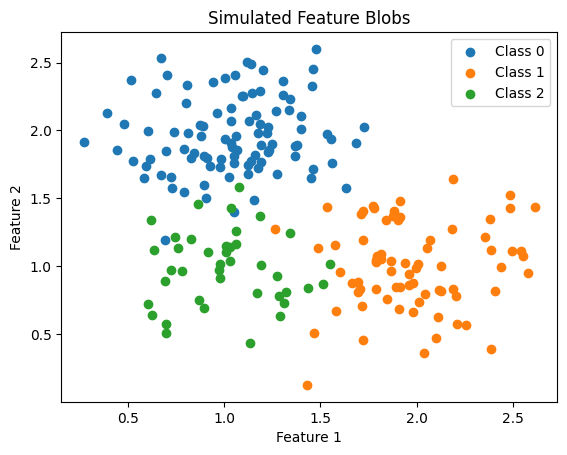

In [4]:
from matplotlib import pyplot as plt
import numpy as np

u_groups, n_per_group = np.unique(groups, return_counts=True)
n_groups = len(u_groups)

assert n_groups == 3

feat_centers = [
    (1, 2),
    (2, 1),
    (1, 1),
]

feat_stds = [
    (0.3, 0.3),
    (0.3, 0.3),
    (0.3, 0.3),
]

X = []
y = []
for i, n_i in enumerate(n_per_group):
    center_i = feat_centers[i]
    stds_i = feat_stds[i]
    X_i = np.random.normal(center_i, stds_i, size=(n_i, 2))
    X.append(X_i)
    y.append(np.full(n_i, i))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

plot_blobs(X=X, y=y)

In [5]:
import scanpy as sc

adata = sc.AnnData(X)
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.leiden(adata, resolution=0.2, flavor="igraph", n_iterations=2)

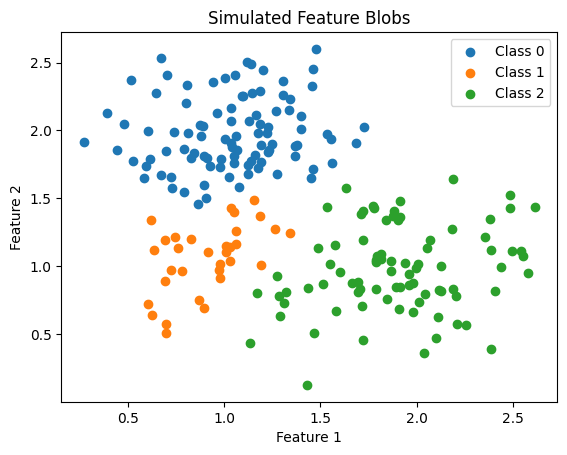

In [6]:
plot_blobs(X=X, y=adata.obs["leiden"])

In [8]:
from overlap import compute_iou_matrix

iou_matrix = compute_iou_matrix(polygons)

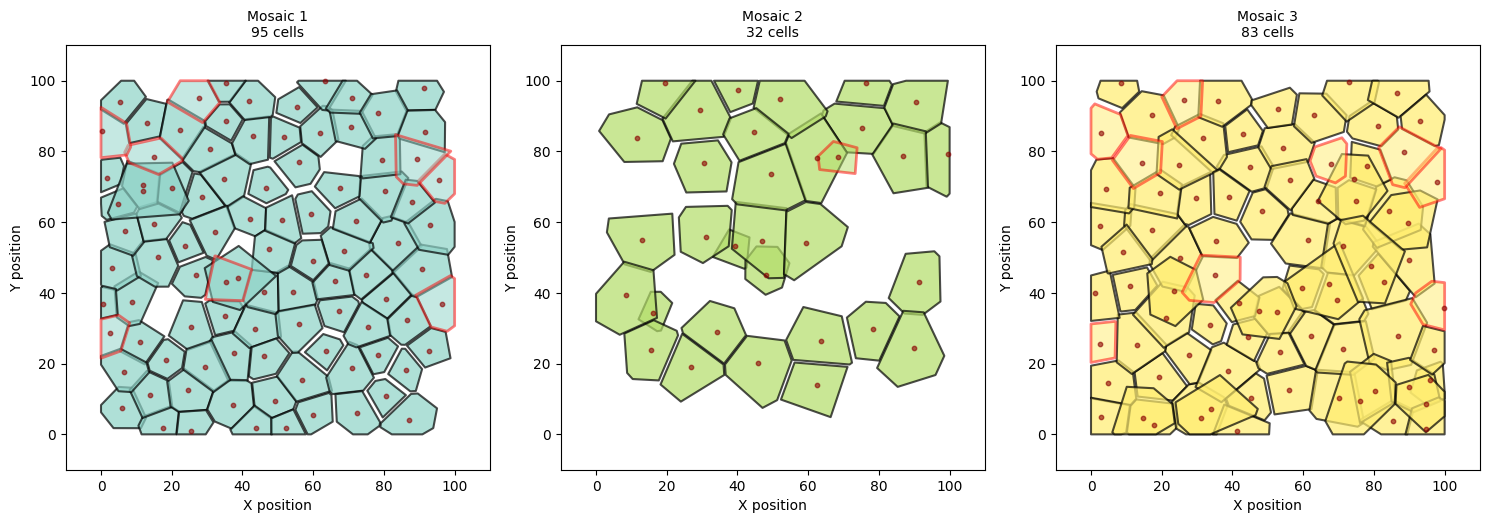

In [10]:
plot_mosaics(adata.obs["leiden"], polygons, centers, np.max(iou_matrix, axis=0)>0.6)

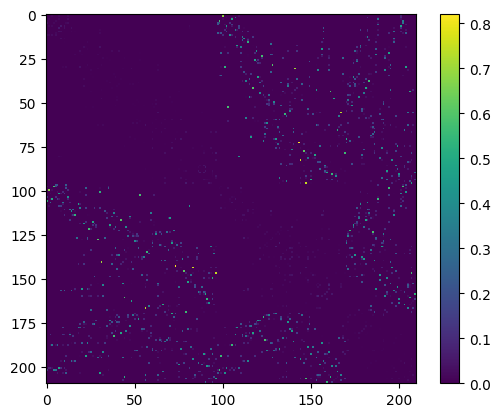

In [11]:
plt.imshow(iou_matrix, interpolation='none')
plt.colorbar()
plt.show()

In [12]:
# 1. Standard Scanpy preprocessing
adata = sc.AnnData(X)

# Normalize/scale if needed
sc.pp.scale(adata)

# Build k-NN graph on morphological features
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', method='umap')

In [20]:
from clustering import apply_mosaic_constraints

# 2. Apply spatial mosaic penalty
adata = apply_mosaic_constraints(
    adata,
    iou_matrix,
    penalty_weight=2.0,
    iou_threshold=0.2,  # Only penalize IoU > 5%
    mode='subtract'
)

In [33]:
from clustering import find_leiden_resolution

final_res = find_leiden_resolution(
    adata, n_groups, adjacency_key='mosaic_connectivities', key_added='leiden_mosaic',
    start_res=1.0, tolerance=0, max_iter=20, verbose=False
)

find_leiden_resolution(
    adata, n_groups, adjacency_key='connectivities', key_added='leiden',
    start_res=final_res, tolerance=0, max_iter=20, verbose=False
)

0.1875

In [34]:
adata.obs["leiden_mosaic"].unique()

['0', '1', '2']
Categories (3, object): ['0', '1', '2']

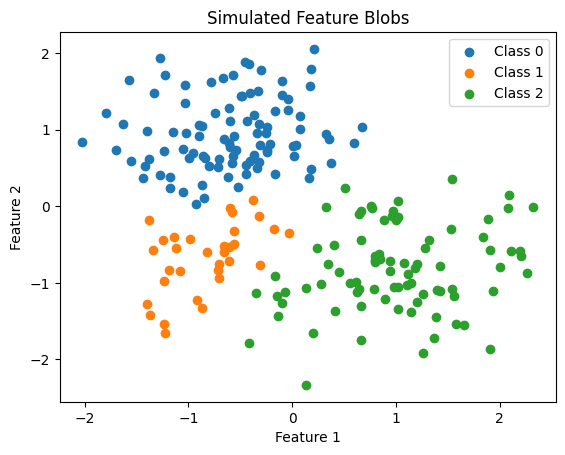

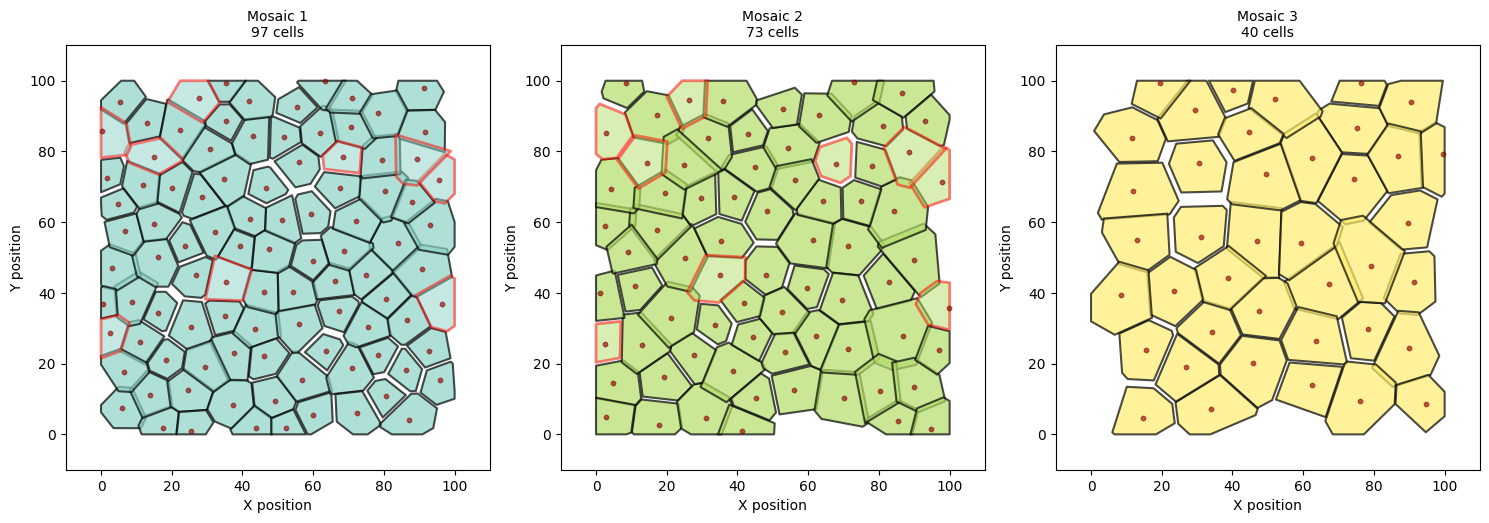

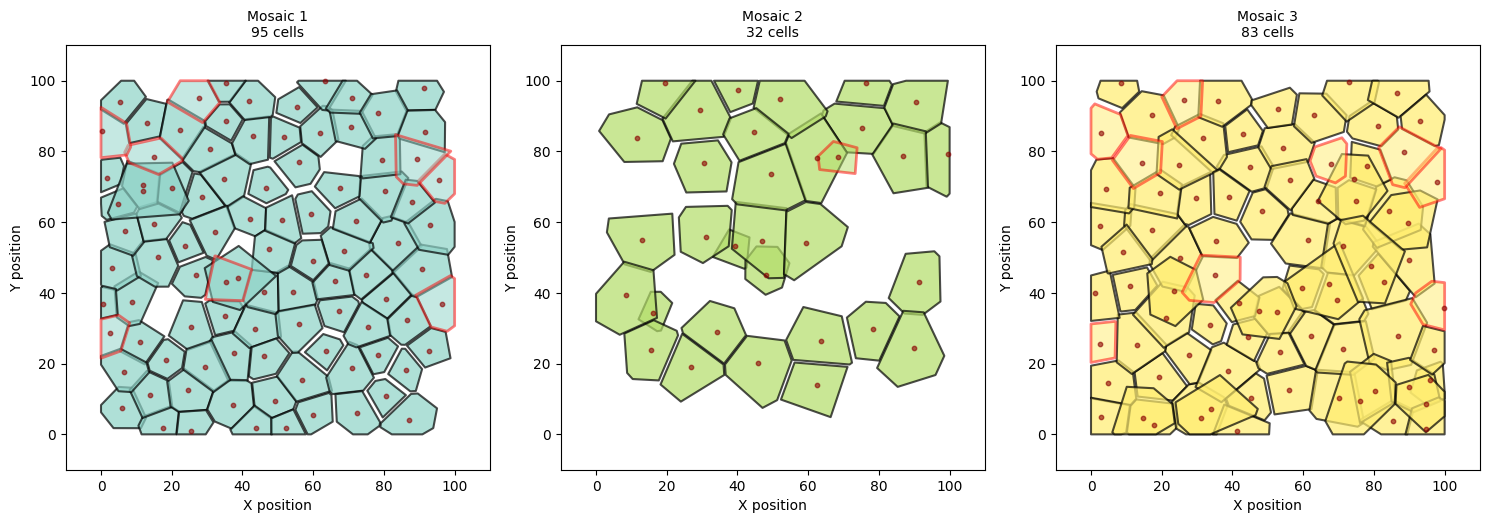

In [35]:
plot_blobs(X=X, y=adata.obs["leiden_mosaic"].astype(int).to_numpy())
plot_mosaics(groups, polygons, centers, np.max(iou_matrix, axis=0)>0.6)
plot_mosaics(adata.obs["leiden_mosaic"], polygons, centers, np.max(iou_matrix, axis=0)>0.6)

In [36]:
from clustering import compare_clustering_mosaic_quality

# 5. Compare mosaic quality
comparison = compare_clustering_mosaic_quality(
    adata,
    iou_matrix,
    standard_key='leiden',
    mosaic_key='leiden_mosaic',
    iou_threshold=0.05
)

print("\nMosaic Quality Comparison:")
print(comparison.groupby('method')[['mean_iou', 'max_iou', 'violations']].mean())


Mosaic Quality Comparison:
              mean_iou   max_iou  violations
method                                      
Mosaic-aware  0.044609  0.431569   18.666667
Standard      0.044609  0.431569   18.666667
